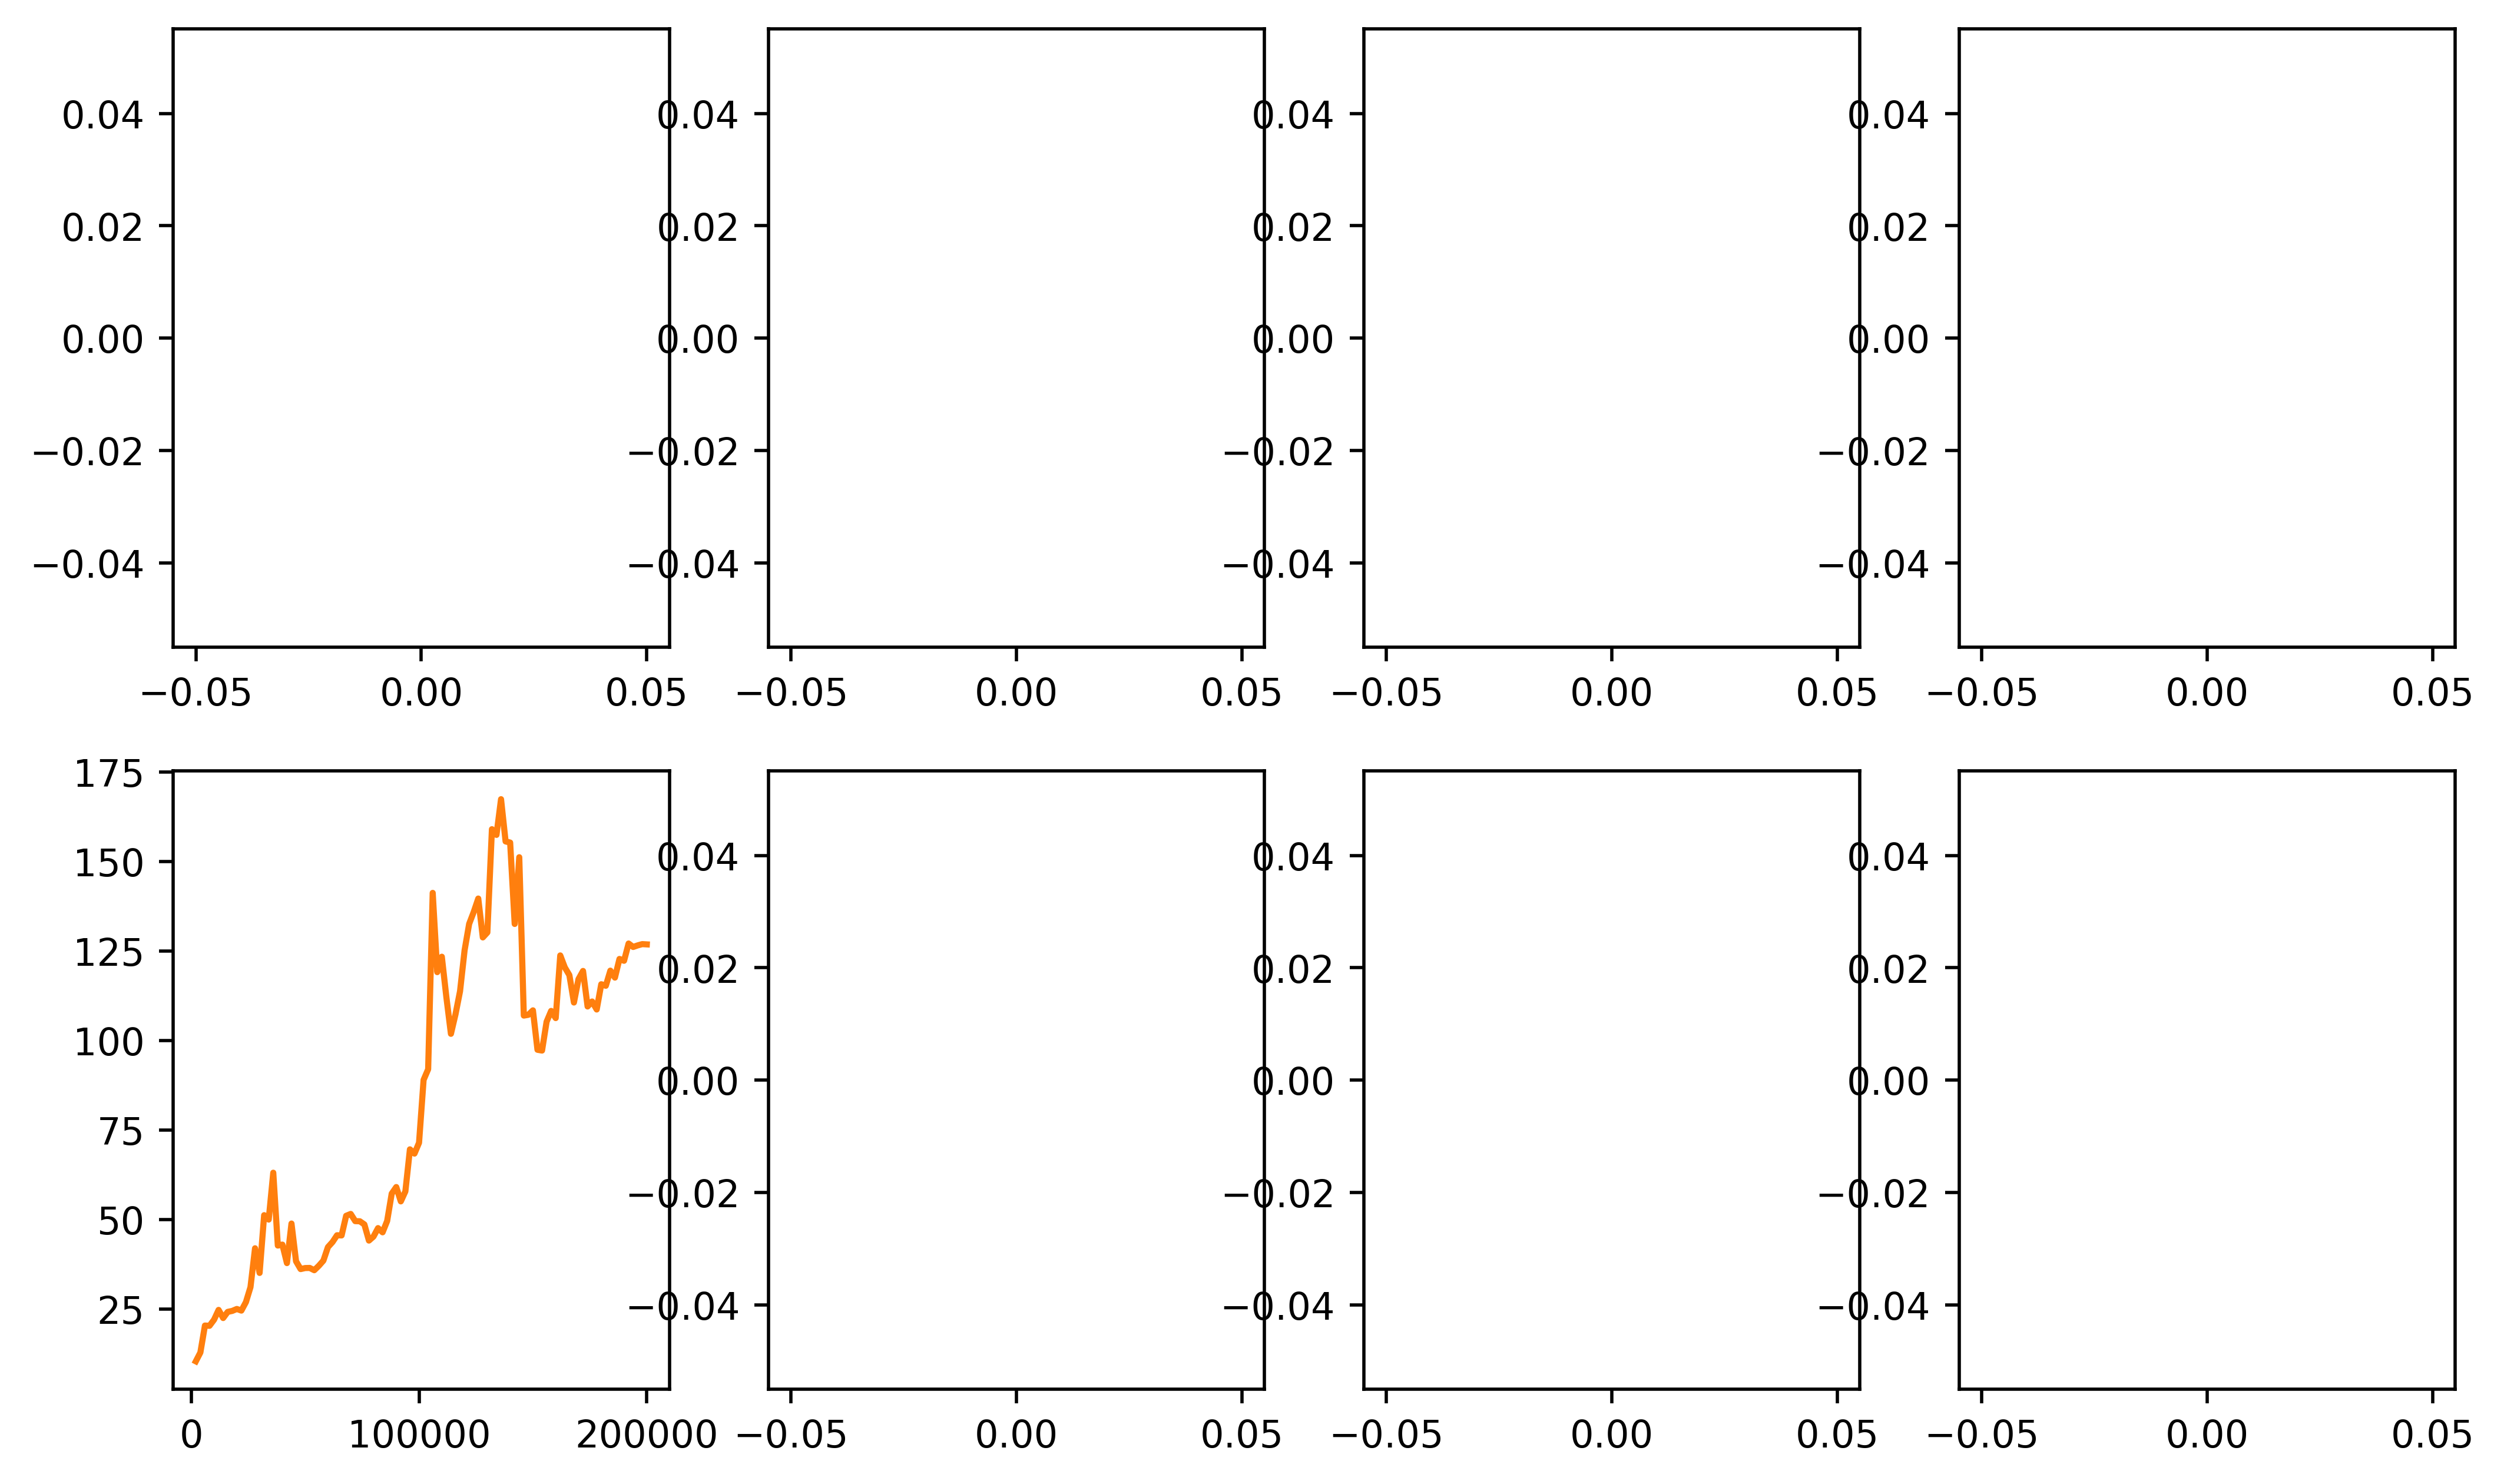

In [26]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

font = {"family": "sans-serif", "weight": "normal", "size": 9.2}
matplotlib.rc("font", **font)

plt.rc("figure", figsize=[10, 6])
plt.rc("figure", titlesize=20)
plt.rc("axes", labelsize=15)
plt.rc("axes", titlesize=15)

base_path = "../../../data/outputs/agent-based/"

fig, axs = plt.subplots(2,4, dpi=500)

evaluations = np.empty((8, 8, 100, 2))
evaluations[:] = np.nan

for i, task in enumerate(["acrobot", "cart_pole", "mountain_car", "mountain_car_continuous", "lunar_lander", "lunar_lander_continuous", "mean", None]):

    for j, transfer in enumerate(["False", "env", "fit", "mem", "env+fit", "env+mem", "fit+mem", "env+fit+mem"]):

        run_num_steps = "infinite" if transfer == "False" else 50

        for k, gen in enumerate(np.arange(1, 101).tolist()):

            file_path = base_path + f"task={task},mode=reinforcement/ae=none/ar=none/algorithm=ga,pop_size=40,net_type=dynamic,run_num_steps={run_num_steps},gen_transfer={transfer},pop_merge=False/{gen}/evaluation.pkl"

            if os.path.isfile(file_path):
                
                with open(file_path, "rb") as f:
                    scores, total_num_env_steps = pickle.load(f)
                
                mean_score = scores.mean()

                evaluations[i,j,k] = [mean_score, total_num_env_steps]

        axs[i%2][i//2].plot(evaluations[i,j,:,1], evaluations[i,j,:,0])